In [1]:
import pandas as pd
import ast
import pytz
import os
import json
import yaml
import glob
from dateutil import tz
from datetime import datetime

class BasePipeline:
    def __init__(self, config, base_file_path):
        self.config = config
        self.base_file_path = base_file_path
        self.geomap = {}
        self._data = pd.DataFrame({})
    
    def construct_file_path(self):
        #TODO: add type to prefix mapping
        file_prefix = 'per_outage' if self.config['type'] == 'o' else 'per_county'
        file_path = f"{self.base_file_path}/{self.config['state']}/layout_{self.config['layout']}/{file_prefix}_{self.config['name']}.csv"
        return file_path.replace('//', '/')

    def load_data(self):
        try:
            file_path = self.construct_file_path()
            print(file_path)
            self._data = pd.read_csv(file_path)
            with open('zip_to_county_name.json', 'r') as json_file:
                self.geomap['zip_to_county_name'] = json.load(json_file)
            with open('zip_to_county_fips.json', 'r') as json_file:
                self.geomap['zip_to_county_fips'] = json.load(json_file)
        except Exception as e:
            print(f"An error occurred during file loading: {e}")
            
    def transform(self):
        raise NotImplementedError

    def standardize(self):
        """
        Generic method to compute and output standardized metrics
        """
        self.load_data()
        self.transform()
        grouped = self._data.groupby('outage_id').apply(self._compute_metrics).reset_index().round(2)
        self._data = pd.merge(grouped, self._data, on=['outage_id', 'timestamp'], how='inner')
        
        self._data['state'] = self.config['state']
        if self.config['state'] != 'ca':
            self._data['utility_provider'] = self.config['name'] 
            self._data['county'] = self._data['zipcode'].map(self.geomap) 
        
        self._data = self._data[[
            'utility_provider', 'state', 'county', 'zipcode',
            'outage_id', 'start_time', 'end_time', 'lat', 'lng', 
            'duration', 'duration_max', 'duration_mean', 'customer_affected_mean', 'total_customer_outage_time', 'total_customer_outage_time_max', 'total_customer_outage_time_mean'
        ]]
        
        return self._data
    
    def output_data(self, standard_data):
        # TODO: Output unified data
        pass
    
    def get_dataframe(self):
        return self._data
    
    def _compute_metrics(self, group):
        """
        Generic method to compute standardized metrics, used for being apply in DataFrame.groupby method, 
        given dataframe being transformed with standardized column names
        """
        duration = (group['end_time'] - group['start_time']).dt.total_seconds() / 60
        duration_max = duration + 15
        duration_mean = (duration + duration_max) / 2
        customer_affected_mean = group['customer_affected'].mean()
        
        total_customer_outage_time = 15 * (group['customer_affected'].sum() - group['customer_affected'].iloc[0]) + (group['timestamp'].iloc[0] - group['start_time'].iloc[0]).total_seconds() / 60 * group['customer_affected'].iloc[0]
        total_customer_outage_time_max = total_customer_outage_time + 15 * group['customer_affected'].iloc[-1]
        total_customer_outage_time_mean = (total_customer_outage_time + total_customer_outage_time_max) / 2

        return pd.Series({
            'timestamp': group['end_time'].iloc[-1],
            'duration': duration.iloc[-1],
            'duration_max': duration_max.iloc[-1],
            'duration_mean': duration_mean.iloc[-1],
            'customer_affected_mean': customer_affected_mean,
            'total_customer_outage_time': total_customer_outage_time,
            'total_customer_outage_time_max': total_customer_outage_time_max,
            'total_customer_outage_time_mean': total_customer_outage_time_mean
        })
        
    def check_vars(self):
        # TODO: Check other useful variables
        pass

In [2]:
class CA1(BasePipeline):
    def load_data(self):
        try:
            dir_path = f"{self.base_file_path}/{self.config['state']}/layout_{self.config['layout']}/"
            csv_files = glob.glob(os.path.join(dir_path, "*.csv"))
            df_list = [pd.read_csv(file) for file in csv_files]
            self._data = pd.concat(df_list, ignore_index=True)
            
            with open('zip_to_county_name.json', 'r') as json_file:
                self.geomap['zip_to_county_name'] = json.load(json_file)
            with open('zip_to_county_fips.json', 'r') as json_file:
                self.geomap['zip_to_county_fips'] = json.load(json_file)
        except Exception as e:
            print(f"An error occurred during file loading: {e}")
    
    def transform(self):
        try:
            # Convert timestamps
            eastern = tz.gettz('US/Eastern')
            pacific = tz.gettz('US/Pacific')
            self._data['StartDate'] = pd.to_datetime(self._data['StartDate'], utc=True).dt.tz_convert(pacific)
            self._data['timestamp'] = pd.to_datetime(self._data['timestamp'], utc=True).dt.tz_convert(eastern)
            self._data = self._data.sort_values(by='timestamp')
            
            # subgroup by timegap rule, must derive subgroup step by step
            self._data['gap'] = (self._data.groupby(['IncidentId', 'x', 'y'])['timestamp'].diff().dt.total_seconds() / 60).round(0).fillna(0)
            self._data['is_gap'] = (self._data.groupby(['IncidentId', 'x', 'y'])['timestamp'].diff() > pd.Timedelta(minutes=20))
            self._data['subgroup'] = self._data.groupby(['IncidentId', 'x', 'y'])['is_gap'].cumsum()
            
            # outage_id candidate
            # self._data['IncidentId+StartDate'] = self._data['IncidentId'].astype(str) + '_' + self._data['StartDate'].dt.strftime('%Y-%m-%d %H:%M:%S')
            self._data['coord'] = list(zip(self._data['x'], self._data['y']))
            # self._data['IncidentId+Coord'] = self._data['IncidentId'].astype(str) + '_' + self._data['coord'].astype(str)
            # self._data['StartDate+Coord'] = self._data['StartDate'].dt.strftime('%Y-%m-%d %H:%M:%S') + '_' + self._data['coord'].astype(str)
            self._data['IncidentId+StartDate+Coord'] = self._data['StartDate'].dt.strftime('%Y-%m-%d %H:%M:%S') + '_' + self._data['coord'].astype(str) + '_' + self._data['IncidentId'].astype(str)
            
            # TODO: get zipcode from lat and long
            self._data['zipcode'] = "000000"
            
            self._data = self._data.rename(columns={
                'x': 'lat',
                'y': 'lng',
                'OutageType': 'is_planned',
                'Cause': 'cause',
                # 'StartDate': 'start_time',
                'ImpactedCustomers': 'customer_affected',
                'UtilityCompany': 'utility_provider',
                'County': 'county'
            })
        except Exception as e:
            print(f"An error occurred during transformation: {e}")
            
    def standardize(self):
        '''
        apply timegap rule to LAWP, identifer rule (IncidentId+StartDate+Coord) to SCE, SDGE, PGE, SMUD
        '''
        self.load_data()
        self.transform()
        lawp = self._data.query('utility_provider == "LAWP"')
        others = self._data.query('utility_provider in ["SCE", "SDGE", "PGE", "SMUD"]')
        
        std_lawp = self._standardize(lawp, method='timegap')
        std_others = self._standardize(others, method='identifier')
        
        std_ca = pd.concat([std_lawp, std_others]).sort_values(by = 'start_time')
        self._data = std_ca
        
        return self._data

    def _standardize(self, df, method='identifier', outage_id='IncidentId+StartDate+Coord'):
        '''
        method: 'identifier' or 'timegap'
        outage_id: id_candidate
        '''
        if method == 'identifier':
            grouped = df.groupby(outage_id).apply(self._identifier_rule).reset_index().round(0)
            df = pd.merge(grouped, df, on=[outage_id, 'timestamp'], how='inner')
            df['outage_id'] = outage_id
        
        elif method == 'timegap':
            df = df.groupby(['IncidentId', 'lat', 'lng', 'subgroup']).apply(self._timegap_rule).reset_index()
            
        return df[[
                'utility_provider', 'county', 
                'outage_id', 'start_time', 'end_time', 'lat', 'lng', 'is_planned', 
                'duration_adj', 'customer_affected_mean', 'cust_affected_x_duration'
            ]]

    
    def _identifier_rule(self, group):
        start_time = group['timestamp'].iloc[0]
        end_time = group['timestamp'].iloc[-1]
        duration_diff = (end_time - start_time).total_seconds() / 60
        duration_15 = 15 * len(group)
        
        group['duration_weight'] = (group['timestamp'].diff().dt.total_seconds() / 60).round(0).fillna(15)
        cust_affected_x_duration = (group['customer_affected'] * group['duration_weight']).sum()
        cust_a_mean = cust_affected_x_duration / group['duration_weight'].sum()
        
        return pd.Series({
            'timestamp': group['timestamp'].iloc[-1],
            'start_time': start_time,
            'end_time': end_time,
            # 'duration_diff': duration_diff,
            # 'duration_15': duration_15,
            'duration_adj': (duration_15 + duration_diff) / 2,
            'customer_affected_mean': cust_a_mean,
            'cust_affected_x_duration': cust_affected_x_duration
        })
    
    def _timegap_rule(self, group):
        outage_id = 'LAWP' + '_' + group['IncidentId'].astype(str) + '_' \
            + group['lat'].astype(str) + '_' + group['lng'].astype(str)+ '_' + group['subgroup'].astype(str)
        start_time = group['timestamp'].iloc[0]
        end_time = group['timestamp'].iloc[-1]
        duration_diff = (end_time - start_time).total_seconds() / 60
        duration_15 = 15 * len(group)
        # duration_diff_minus_15 = duration_diff - duration_15
        cust_a_mean = group['customer_affected'].mean()

        return pd.Series({
            'county': group['county'].unique(),
            'utility_provider': group['utility_provider'].iloc[0],
            'is_planned': group['is_planned'].unique(),
            'cause': group['cause'].unique(),
            'outage_id': outage_id,
            'start_time': start_time,
            'end_time': end_time,
            # 'duration_diff': duration_diff,
            # 'duration_15': duration_15,
            'duration_adj': (duration_15 + duration_diff) / 2,
            # 'duration_diff_minus_15': duration_diff_minus_15,
            'customer_affected_mean': cust_a_mean,
            'cust_affected_x_duration' : cust_a_mean * (duration_15 + duration_diff) / 2
            # 'n_StartDate': group['start_date'].nunique(),
            # 'n_OBJECTID': group['OBJECTID'].nunique()
        })
        

In [4]:
with open('/Users/xuanedx1/github/outage-data-scraper/app/pipeline/config.yaml', 'r') as file:
    config = yaml.safe_load(file)
    base_file_path = config['globals']['LOCAL_FILE_BASE_PATH']

# Instantiate a BasePipeline object for each provider in the configuration
for provider in config['providers']:
    pipeline = CA1(provider, base_file_path)
    pipeline.standardize()
    display(pipeline._data)

/var/folders/3j/7cy055ys1yz5dcj9cwbxbw8h0000gp/T/ipykernel_4610/2128296599.py:6: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  df_list = [pd.read_csv(file) for file in csv_files]


,utility_provider,county,outage_id,start_time,end_time,lat,lng,is_planned,duration_adj,customer_affected_mean,cust_affected_x_duration
379,PGE,PLACER,IncidentId+StartDate+Coord,2023-03-29 18:05:07-04:00,2023-03-29 22:05:06-04:00,-120.826990,39.209490,Not Planned,247.0,12.0,3060.0
403,PGE,ALAMEDA,IncidentId+StartDate+Coord,2023-03-29 18:05:07-04:00,2023-03-29 18:05:07-04:00,-122.278640,37.813830,Not Planned,8.0,21.0,315.0
402,SCE,TULARE,IncidentId+StartDate+Coord,2023-03-29 18:05:07-04:00,2023-03-29 23:20:06-04:00,-119.051358,36.088595,Planned,322.0,42.0,13860.0
401,SCE,LOS ANGELES,IncidentId+StartDate+Coord,2023-03-29 18:05:07-04:00,2023-03-29 23:20:06-04:00,-118.467299,34.029634,Planned,322.0,16.0,5280.0
400,SCE,LOS ANGELES,IncidentId+StartDate+Coord,2023-03-29 18:05:07-04:00,2023-03-29 23:20:06-04:00,-118.464990,34.030477,Planned,322.0,1.0,330.0
...,...,...,...,...,...,...,...,...,...,...,...
319255,SCE,SAN BERNARDINO,IncidentId+StartDate+Coord,2024-03-01 12:21:09-05:00,2024-03-01 12:21:09-05:00,-117.299159,34.139557,Not Planned,8.0,8.0,120.0
319229,SCE,LOS ANGELES,IncidentId+StartDate+Coord,2024-03-01 12:21:09-05:00,2024-03-01 12:21:09-05:00,-117.794952,34.107882,Not Planned,8.0,4.0,60.0
319259,SCE,RIVERSIDE,IncidentId+StartDate+Coord,2024-03-01 12:21:09-05:00,2024-03-01 12:21:09-05:00,-117.417281,33.640173,Planned,8.0,216.0,3240.0
319417,SDGE,SAN DIEGO,IncidentId+StartDate+Coord,2024-03-01 12:21:09-05:00,2024-03-01 12:21:09-05:00,-116.272350,32.662407,Planned,8.0,1.0,15.0


In [7]:
# pipeline._data.to_csv(f"{pipeline.config['name']}_outage_level-v1.csv")

,0,1,2,3,4
Utility Provider,LAWP,SCE,SDGE,PGE,SMUD
Number of Rows,186047,82907,31761,195400,9366
Mean Duration,25.888626,13092.491732,60271.294858,226.613608,123.659086


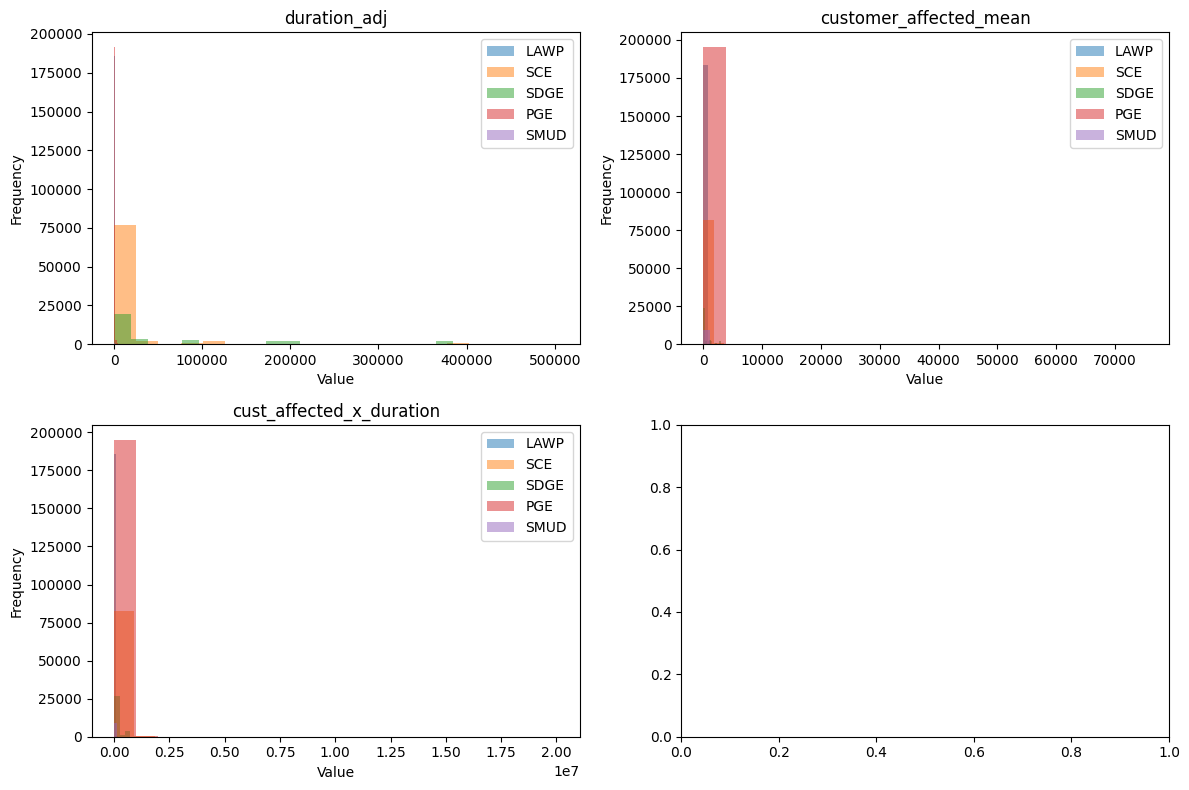

In [5]:

def calculate_statistics_per_provider(df):
    # Filter dataframe for specified utility providers
    utility_providers = ['LAWP', 'SCE', 'SDGE', 'PGE', 'SMUD']
    filtered_dfs = {provider: df[df['utility_provider'] == provider] for provider in utility_providers}
    
    # Calculate statistics for each provider and store in a list of dictionaries
    stats_list = []
    for provider, filtered_df in filtered_dfs.items():
        num_rows = len(filtered_df)
        mean_duration = filtered_df['duration_adj'].mean()
        stats_list.append({'Utility Provider': provider, 'Number of Rows': num_rows, 'Mean Duration': mean_duration})
    
    # Create DataFrame from the list of dictionaries
    statistics_df = pd.DataFrame(stats_list)
    
    return statistics_df

# Example usage:
# df is your DataFrame containing the data
# Replace it with your actual DataFrame
statistics_df = calculate_statistics_per_provider(pipeline._data)
statistics_df.transpose()

In [ ]:
import matplotlib.pyplot as plt

def plot_histograms_per_provider(df):
    # Filter dataframe for specified utility providers
    utility_providers = ['LAWP', 'SCE', 'SDGE', 'PGE', 'SMUD']
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))
    axs = axs.flatten()
    
    for i, provider in enumerate(utility_providers):
        provider_df = df[df['utility_provider'] == provider]
        columns_to_plot = ['duration_adj', 'customer_affected_mean', 'cust_affected_x_duration']
        
        for j, column in enumerate(columns_to_plot):
            ax = axs[j]
            ax.hist(provider_df[column], bins=20, alpha=0.5, label=provider)
            ax.set_title(column)
            ax.set_xlabel('Value')
            ax.set_ylabel('Frequency')
            ax.legend()
    
    # Adjust layout
    plt.tight_layout()
    plt.show()

# Example usage:
# df is your DataFrame containing the data
# Replace it with your actual DataFrame
plot_histograms_per_provider(pipeline._data)

In [6]:
pipeline._data.groupby(['utility_provider'])['duration'].describe()

NameError: name 'ca' is not defined

In [89]:
pipeline._data[pipeline._data['duration'] == -14466.03]

,utility_provider,state,county,zipcode,outage_id,start_time,end_time,is_planned,cause,lat,lng,duration,duration_max,duration_mean,customer_affected_mean,total_customer_outage_time,total_customer_outage_time_max,total_customer_outage_time_mean
43716,SCE,ca,ORANGE,000000,SCE 128939199_2023-06-05 02:00:00,2023-06-05 02:00:00-07:00,2023-05-26 03:53:58-04:00,Planned,Pole Upgrade,-117.890297,33.765027,-14466.03,-14451.03,-14458.53,226.0,-3743931.07,-3740541.07,-3742236.07


In [90]:
ca[ca['IncidentId'] == 'SCE 128939199']

,OBJECTID,UtilityCompany,StartDate,EstimatedRestoreDate,Cause,ImpactedCustomers,County,OutageStatus,OutageType,GlobalID,OutageTypeColor,OutageStatusColor,IncidentId,x,y,timestamp,coord
1020523,2220334,SCE,2023-05-24 15:05:00,2023-05-24 19:15:00,Pole Upgrade,226,ORANGE,Active,Planned,ec9b8429-d349-4bf9-9a5d-7048d36318a6,#a8a800,NaN,SCE 128939199,-117.890297,33.765027,2023-05-24 13:06:34-04:00,"(-117.89029725, 33.765026500003536)"
1020858,2220334,SCE,2023-05-24 15:05:00,2023-05-24 19:15:00,Pole Upgrade,226,ORANGE,Active,Planned,ec9b8429-d349-4bf9-9a5d-7048d36318a6,#a8a800,NaN,SCE 128939199,-117.890297,33.765027,2023-05-24 13:20:23-04:00,"(-117.89029725, 33.765026500003536)"
1021196,2220334,SCE,2023-06-05 09:00:00,2023-06-05 16:45:00,Pole Upgrade,226,ORANGE,Active,Planned,ec9b8429-d349-4bf9-9a5d-7048d36318a6,#a8a800,NaN,SCE 128939199,-117.890297,33.765027,2023-05-24 13:53:56-04:00,"(-117.89029725, 33.765026500003536)"
1021478,2220334,SCE,2023-06-05 09:00:00,2023-06-05 16:45:00,Pole Upgrade,226,ORANGE,Active,Planned,ec9b8429-d349-4bf9-9a5d-7048d36318a6,#a8a800,NaN,SCE 128939199,-117.890297,33.765027,2023-05-24 23:51:39-04:00,"(-117.89029725, 33.765026500003536)"
1021602,2220334,SCE,2023-06-05 09:00:00,2023-06-05 16:45:00,Pole Upgrade,226,ORANGE,Active,Planned,ec9b8429-d349-4bf9-9a5d-7048d36318a6,#a8a800,NaN,SCE 128939199,-117.890297,33.765027,2023-05-25 00:50:06-04:00,"(-117.89029725, 33.765026500003536)"
1021718,2220334,SCE,2023-06-05 09:00:00,2023-06-05 16:45:00,Pole Upgrade,226,ORANGE,Active,Planned,ec9b8429-d349-4bf9-9a5d-7048d36318a6,#a8a800,NaN,SCE 128939199,-117.890297,33.765027,2023-05-25 01:50:06-04:00,"(-117.89029725, 33.765026500003536)"
1021812,2220334,SCE,2023-06-05 09:00:00,2023-06-05 16:45:00,Pole Upgrade,226,ORANGE,Active,Planned,ec9b8429-d349-4bf9-9a5d-7048d36318a6,#a8a800,NaN,SCE 128939199,-117.890297,33.765027,2023-05-25 13:38:55-04:00,"(-117.89029725, 33.765026500003536)"
1022131,2220334,SCE,2023-06-05 09:00:00,2023-06-05 16:45:00,Pole Upgrade,226,ORANGE,Active,Planned,ec9b8429-d349-4bf9-9a5d-7048d36318a6,#a8a800,NaN,SCE 128939199,-117.890297,33.765027,2023-05-25 14:36:30-04:00,"(-117.89029725, 33.765026500003536)"
1022463,2220334,SCE,2023-06-05 09:00:00,2023-06-05 16:45:00,Pole Upgrade,226,ORANGE,Active,Planned,ec9b8429-d349-4bf9-9a5d-7048d36318a6,#a8a800,NaN,SCE 128939199,-117.890297,33.765027,2023-05-25 16:35:06-04:00,"(-117.89029725, 33.765026500003536)"
1022753,2220334,SCE,2023-06-05 09:00:00,2023-06-05 16:45:00,Pole Upgrade,226,ORANGE,Active,Planned,ec9b8429-d349-4bf9-9a5d-7048d36318a6,#a8a800,NaN,SCE 128939199,-117.890297,33.765027,2023-05-25 20:51:41-04:00,"(-117.89029725, 33.765026500003536)"


In [14]:
# planned or not 
grouped = ca.groupby(['UtilityCompany', 'OutageType']).size().reset_index(name='Count')

# Calculate the total count of 'OutageType' for each 'UtilityCompany'
total_counts = grouped.groupby('UtilityCompany')['Count'].sum()

# Merge the grouped dataframe with the total counts dataframe
merged = pd.merge(grouped, total_counts, on='UtilityCompany', suffixes=('', '_total'))

# Calculate percentage
merged['Percentage'] = (merged['Count'] / merged['Count_total']) * 100

# Drop unnecessary columns
result = merged.drop(columns=['Count', 'Count_total'])

print(result)

  UtilityCompany   OutageType  Percentage
0           LAWP  Not Planned  100.000000
1            PGE  Not Planned  100.000000
2            SCE  Not Planned   20.404239
3            SCE      Planned   79.595761
4           SDGE  Not Planned    7.179194
5           SDGE      Planned   92.820806
6           SMUD  Not Planned   55.037622
7           SMUD      Planned   44.962378


In [ ]:
pipeline._data[pipeline._data['duration'] < 0 ]

---

In [3]:
ca = pd.read_csv('/Users/xuanedx1/github/outage-data-scraper/data/s3/ca/layout_investor/per_outage_investor_owned.csv')

In [5]:
eastern = tz.gettz('US/Eastern')
pacific = tz.gettz('US/Pacific')
utc = tz.gettz('UTC')
ca['StartDate'] = pd.to_datetime(ca['StartDate'], utc=True).dt.tz_convert(pacific)
ca['timestamp'] = pd.to_datetime(ca['timestamp'], utc=True).dt.tz_convert(eastern)
ca

,OBJECTID,UtilityCompany,StartDate,EstimatedRestoreDate,Cause,ImpactedCustomers,County,OutageStatus,OutageType,GlobalID,OutageTypeColor,OutageStatusColor,IncidentId,x,y,timestamp
0,2164236,LAWP,2023-03-29 14:48:19.243000-07:00,2023-03-29 20:00:00,Unknown,1,LOS ANGELES,Active,Not Planned,84a9a053-1659-4302-a48b-e882df433da3,#ffaa00,NaN,6,-118.442245,34.150712,2023-03-29 18:05:07-04:00
1,2164360,LAWP,2023-03-29 14:48:19.243000-07:00,2023-03-29 17:30:00,Unknown,1,LOS ANGELES,Active,Not Planned,8be57f57-ff46-4563-9fc0-dff6d2dfdcca,#ffaa00,NaN,7,-118.352399,34.079090,2023-03-29 18:05:07-04:00
2,2164361,LAWP,2023-03-29 14:48:19.243000-07:00,2023-03-29 17:30:00,Unknown,1,LOS ANGELES,Active,Not Planned,9c21f562-6a0f-453a-bd9e-075d233298cf,#ffaa00,NaN,8,-118.442245,34.150712,2023-03-29 18:05:07-04:00
3,2164432,LAWP,2023-03-29 14:48:19.243000-07:00,2023-03-29 21:30:00,Unknown,1,LOS ANGELES,Active,Not Planned,096422f7-eb86-4099-a5f0-a7a2715a7df7,#ffaa00,NaN,9,-118.352399,34.079090,2023-03-29 18:05:07-04:00
4,2167231,LAWP,2023-03-29 14:48:19.243000-07:00,NaN,Unknown,7,LOS ANGELES,Active,Not Planned,839f6d96-4d8c-4c2b-9b31-35b16492a4f9,#ffaa00,NaN,5,-118.298986,34.001976,2023-03-29 18:05:07-04:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1029465,2229613,PGE,2023-06-04 06:50:00-07:00,2023-06-04 15:30:00,NaN,1,SANTA CRUZ,Active,Not Planned,414a4e73-c299-4e1b-ac11-e5f0440fde7b,#ffaa00,NaN,2128302,-121.997820,37.153850,2023-06-04 10:21:40-04:00
1029466,2229614,PGE,2023-06-04 04:44:10-07:00,2023-06-04 17:45:00,NaN,28,SONOMA,Active,Not Planned,84b3903b-90ca-4695-b482-1100b3bde112,#ffaa00,NaN,2128303,-123.063650,38.350130,2023-06-04 10:21:40-04:00
1029467,2229615,PGE,2023-06-04 06:50:00-07:00,2023-06-04 17:30:00,NaN,1589,MADERA,Active,Not Planned,56e81e6c-8dfa-40c2-90d6-70cf998bd265,#ffaa00,NaN,2128307,-119.710260,37.228700,2023-06-04 10:21:40-04:00
1029468,2229616,SDGE,2023-06-04 00:11:00-07:00,2023-06-04 15:00:00,Upgrading the electric system in your area req...,1,SAN DIEGO,Active,Planned,dadc8429-7131-43e3-8d31-b6a4e89a140a,#a8a800,NaN,1011382,-116.675996,33.247166,2023-06-04 10:21:40-04:00


In [15]:
ca[(ca['StartDate'] >= ca['timestamp'])].sort_values(by='IncidentId').head(20)

,OBJECTID,UtilityCompany,StartDate,EstimatedRestoreDate,Cause,ImpactedCustomers,County,OutageStatus,OutageType,GlobalID,OutageTypeColor,OutageStatusColor,IncidentId,x,y,timestamp
36851,2175846,SMUD,2023-03-31 13:58:00-07:00,NaN,We're assessing the outage,1,SACRAMENTO,Active,Not Planned,81b22490-083b-4325-b424-e1e1f2e84cd1,#ffaa00,NaN,D23033000103,-121.478420,38.510452,2023-03-30 22:35:06-04:00
35695,2175846,SMUD,2023-03-31 13:58:00-07:00,NaN,We're assessing the outage,1,SACRAMENTO,Active,Not Planned,81b22490-083b-4325-b424-e1e1f2e84cd1,#ffaa00,NaN,D23033000103,-121.478420,38.510452,2023-03-30 21:35:06-04:00
35385,2175846,SMUD,2023-03-31 13:58:00-07:00,NaN,We're assessing the outage,1,SACRAMENTO,Active,Not Planned,81b22490-083b-4325-b424-e1e1f2e84cd1,#ffaa00,NaN,D23033000103,-121.478420,38.510452,2023-03-30 21:20:06-04:00
36278,2175846,SMUD,2023-03-31 13:58:00-07:00,NaN,We're assessing the outage,1,SACRAMENTO,Active,Not Planned,81b22490-083b-4325-b424-e1e1f2e84cd1,#ffaa00,NaN,D23033000103,-121.478420,38.510452,2023-03-30 22:05:06-04:00
35070,2175846,SMUD,2023-03-31 13:58:00-07:00,NaN,We're assessing the outage,1,SACRAMENTO,Active,Not Planned,81b22490-083b-4325-b424-e1e1f2e84cd1,#ffaa00,NaN,D23033000103,-121.478420,38.510452,2023-03-30 21:05:06-04:00
36564,2175846,SMUD,2023-03-31 13:58:00-07:00,NaN,We're assessing the outage,1,SACRAMENTO,Active,Not Planned,81b22490-083b-4325-b424-e1e1f2e84cd1,#ffaa00,NaN,D23033000103,-121.478420,38.510452,2023-03-30 22:20:06-04:00
34757,2175846,SMUD,2023-03-31 13:58:00-07:00,NaN,We're assessing the outage,1,SACRAMENTO,Active,Not Planned,81b22490-083b-4325-b424-e1e1f2e84cd1,#ffaa00,NaN,D23033000103,-121.478420,38.510452,2023-03-30 20:50:07-04:00
34442,2175846,SMUD,2023-03-31 13:58:00-07:00,NaN,We're assessing the outage,1,SACRAMENTO,Active,Not Planned,81b22490-083b-4325-b424-e1e1f2e84cd1,#ffaa00,NaN,D23033000103,-121.478420,38.510452,2023-03-30 20:35:07-04:00
37131,2175846,SMUD,2023-03-31 13:58:00-07:00,NaN,We're assessing the outage,1,SACRAMENTO,Active,Not Planned,81b22490-083b-4325-b424-e1e1f2e84cd1,#ffaa00,NaN,D23033000103,-121.478420,38.510452,2023-03-30 22:50:06-04:00
34114,2175846,SMUD,2023-03-31 13:58:00-07:00,NaN,We're assessing the outage,1,SACRAMENTO,Active,Not Planned,81b22490-083b-4325-b424-e1e1f2e84cd1,#ffaa00,NaN,D23033000103,-121.478420,38.510452,2023-03-30 20:20:06-04:00


In [10]:
ca[(ca['StartDate'] >= ca['timestamp'])]['UtilityCompany'].unique()

array(['SCE', 'SMUD'], dtype=object)

In [9]:
# ca['coord'] = list(zip(ca['x'], ca['y']))
ca['timestamp'] = pd.to_datetime(ca['timestamp'])
ca = ca.sort_values(by='timestamp')
ca['time_diff'] = (ca.groupby(['IncidentId', 'x', 'y'])['timestamp'].diff().dt.total_seconds() / 60).round(0).fillna(0)
ca['is_gap'] = (ca.groupby(['IncidentId', 'x', 'y'])['timestamp'].diff() > pd.Timedelta(minutes=20))
ca['subgroup'] = ca.groupby(['IncidentId', 'x', 'y'])['is_gap'].cumsum()

In [10]:
sce = ca[ca['UtilityCompany'] == 'SCE']
lawp = ca[ca['UtilityCompany'] == 'LAWP']
sdge = ca[ca['UtilityCompany'] == 'SDGE']
pge = ca[ca['UtilityCompany'] == 'PGE']
smud = ca[ca['UtilityCompany'] == 'SMUD']

In [218]:
lawp['timestamp'] = pd.to_datetime(lawp['timestamp'])
lawp = lawp.sort_values(by='timestamp')
lawp['time_diff'] = (lawp.groupby(['IncidentId', 'x', 'y'])['timestamp'].diff().dt.total_seconds() / 60).round(0).fillna(0)
lawp['is_gap'] = (lawp.groupby(['IncidentId', 'x', 'y'])['timestamp'].diff() > pd.Timedelta(minutes=20))
lawp['subgroup'] = lawp.groupby(['IncidentId', 'x', 'y'])['is_gap'].cumsum()

In [219]:
lawp['subgroup'] = lawp.groupby(['IncidentId', 'x', 'y'])['is_gap'].cumsum()

In [11]:
def compute(group):
    '''compute metrics of interest'''
    county = group['County'].unique()
    IncidentId = group['IncidentId'].unique()
    x = group['x'].unique()
    y = group['y'].unique()
    start_time = group['timestamp'].iloc[0]
    end_time = group['timestamp'].iloc[-1]
    duration_diff = (end_time - start_time).total_seconds() / 60
    duration_15 = 15 * len(group)
    duration_diff_minus_15 = duration_diff - duration_15
    cust_a_mean = group['ImpactedCustomers'].mean()
    n_startdate = group['StartDate'].nunique()
    n_OBJECTID = group['OBJECTID'].nunique()

    return pd.Series({
        'county': county,
        'IncidenId': IncidentId,
        'x': x,
        'y': y,
        'start_time': start_time,
        'end_time': end_time,
        'duration_diff': duration_diff,
        'duration_15': duration_15,
        'duration_diff_minus_15': duration_diff_minus_15,
        'cust_a_mean': cust_a_mean,
        'n_StartDate': n_startdate,
        'n_OBJECTID': n_OBJECTID
    })

In [25]:
# groups = lawp.groupby(['IncidentId', 'x', 'y', 'subgroup'])
# groups = sce.groupby(['IncidentId', 'x', 'y', 'subgroup'])
groups = sdge.groupby(['IncidentId', 'x', 'y', 'subgroup'])
# groups = pge.groupby(['IncidentId', 'x', 'y', 'subgroup'])
# groups = smud.groupby(['IncidentId', 'x', 'y', 'subgroup'])

In [26]:
result = groups.apply(compute).reset_index(drop=True)

In [27]:
result

,county,IncidenId,x,y,start_time,end_time,duration_diff,duration_15,duration_diff_minus_15,cust_a_mean,n_StartDate,n_OBJECTID
0,[SAN DIEGO],[1000000],[-117.33251425689998],[33.13748009930001],2023-04-18 09:20:06,2023-04-18 13:50:06,270.000000,285,-15.000000,64.000000,1,1
1,[SAN DIEGO],[1000005],[-117.0915525501],[32.6580429042],2023-04-18 12:35:06,2023-04-18 14:05:08,90.033333,105,-14.966667,42.000000,1,1
2,[SAN DIEGO],[1000006],[-117.0915525501],[32.6580429042],2023-04-18 12:35:06,2023-04-18 14:05:08,90.033333,105,-14.966667,34.000000,1,1
3,[SAN DIEGO],[1000007],[-117.0915525501],[32.6580429042],2023-04-18 12:35:06,2023-04-18 14:05:08,90.033333,105,-14.966667,2.000000,1,1
4,[ORANGE],[1000010],[-117.67339653],[33.563061502999986],2023-04-18 12:50:06,2023-04-18 14:35:07,105.016667,120,-14.983333,1260.000000,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
4067,[ORANGE],[999924],[-117.5890331169],[33.4569555663],2023-04-18 22:50:06,2023-04-18 22:50:06,0.000000,15,-15.000000,0.000000,1,1
4068,[SAN DIEGO],[999938],[-117.0858485651],[33.253260920299994],2023-04-17 21:35:06,2023-04-17 22:20:07,45.016667,60,-14.983333,5.000000,1,1
4069,[SAN DIEGO],[999986],[-117.2335391259],[32.74153546219999],2023-04-18 06:05:06,2023-04-18 06:35:06,30.000000,45,-15.000000,31.000000,1,1
4070,[SAN DIEGO],[999992],[-117.0915525501],[32.6580429042],2023-04-18 07:05:06,2023-04-18 12:20:06,315.000000,330,-15.000000,81.545455,1,1


In [ ]:
result.describe()

df = result
# Plot histograms for numerical variables
for column in df.columns:
    if pd.api.types.is_numeric_dtype(df[column]):
        plt.figure()
        df[column].plot(kind='hist', bins=50, title=column)
        plt.xlabel(column)
        plt.ylabel('Frequency')

plt.show()

In [227]:
result[result['duration_diff_minus_15'] == -195.000000]

,county,IncidenId,x,y,start_time,end_time,duration_diff,duration_15,duration_diff_minus_15,cust_a_mean,n_StartDate,n_OBJECTID
2206,[LOS ANGELES],[23],[-118.4320618140021],[34.241410434001146],2023-05-15 22:05:06,2023-05-16 02:20:06,255.0,450,-195.0,37.233333,18,3


In [228]:
import numpy as np
lawp.query('IncidentId == "35" & x == -118.330764 & y == 34.094954')

tolerance = 1e-6  # Adjust the tolerance level as needed

lawp[(lawp['IncidentId'] == "23") & 
              (np.isclose(lawp['x'], -118.4320618140021, atol=tolerance)) & 
              (np.isclose(lawp['y'], 34.241410434001146, atol=tolerance))]

,OBJECTID,UtilityCompany,StartDate,EstimatedRestoreDate,Cause,ImpactedCustomers,County,OutageStatus,OutageType,GlobalID,...,OutageStatusColor,IncidentId,x,y,timestamp,coord,time_diff,is_continuous,subgroup,is_gap
932061,2212552,LAWP,2023-05-15 22:03:39.699000,2023-05-15 19:00:00,Unknown,1,LOS ANGELES,Active,Not Planned,d965115e-79d7-4904-947d-67ff390747b5,...,NaN,23,-118.432062,34.24141,2023-05-15 22:05:06,"(-118.4320618140021, 34.241410434001146)",0.0,False,0,False
932312,2212552,LAWP,2023-05-15 22:15:55.977000,NaN,Unknown,1,LOS ANGELES,Active,Not Planned,d965115e-79d7-4904-947d-67ff390747b5,...,NaN,23,-118.432062,34.24141,2023-05-15 22:20:07,"(-118.4320618140021, 34.241410434001146)",15.0,False,0,False
932551,2212552,LAWP,2023-05-15 22:32:19.722000,2023-05-15 15:00:00,Unknown,1,LOS ANGELES,Active,Not Planned,d965115e-79d7-4904-947d-67ff390747b5,...,NaN,23,-118.432062,34.24141,2023-05-15 22:35:07,"(-118.4320618140021, 34.241410434001146)",15.0,False,0,False
932627,2212631,LAWP,2023-05-15 22:01:55.008000,2023-05-15 19:00:00,Unknown,1,LOS ANGELES,Active,Not Planned,c7a091d8-f6cf-4e0e-a4b0-5fa7a5c172c5,...,NaN,23,-118.432062,34.24141,2023-05-15 22:35:07,"(-118.4320618140021, 34.241410434001146)",0.0,False,0,False
932601,2212605,LAWP,2023-05-15 22:01:55.008000,2023-05-15 19:00:00,Unknown,1,LOS ANGELES,Active,Not Planned,0d336e7f-9752-4cff-9a2a-a668ff214812,...,NaN,23,-118.432062,34.24141,2023-05-15 22:35:07,"(-118.4320618140021, 34.241410434001146)",0.0,False,0,False
932902,2212631,LAWP,2023-05-15 22:45:39.106000,2023-05-15 23:30:00,Unknown,1,LOS ANGELES,Active,Not Planned,c7a091d8-f6cf-4e0e-a4b0-5fa7a5c172c5,...,NaN,23,-118.432062,34.24141,2023-05-15 22:50:07,"(-118.4320618140021, 34.241410434001146)",15.0,False,0,False
932832,2212552,LAWP,2023-05-15 22:45:39.106000,2023-05-15 23:30:00,Unknown,1,LOS ANGELES,Active,Not Planned,d965115e-79d7-4904-947d-67ff390747b5,...,NaN,23,-118.432062,34.24141,2023-05-15 22:50:07,"(-118.4320618140021, 34.241410434001146)",0.0,False,0,False
932879,2212605,LAWP,2023-05-15 22:45:39.106000,2023-05-15 23:30:00,Unknown,1,LOS ANGELES,Active,Not Planned,0d336e7f-9752-4cff-9a2a-a668ff214812,...,NaN,23,-118.432062,34.24141,2023-05-15 22:50:07,"(-118.4320618140021, 34.241410434001146)",0.0,False,0,False
933119,2212552,LAWP,2023-05-15 22:45:39.106000,2023-05-15 23:30:00,Unknown,1,LOS ANGELES,Active,Not Planned,d965115e-79d7-4904-947d-67ff390747b5,...,NaN,23,-118.432062,34.24141,2023-05-15 23:05:06,"(-118.4320618140021, 34.241410434001146)",15.0,False,0,False
933166,2212605,LAWP,2023-05-15 22:45:39.106000,2023-05-15 23:30:00,Unknown,1,LOS ANGELES,Active,Not Planned,0d336e7f-9752-4cff-9a2a-a668ff214812,...,NaN,23,-118.432062,34.24141,2023-05-15 23:05:06,"(-118.4320618140021, 34.241410434001146)",0.0,False,0,False


In [153]:
lawp.query('IncidentId == "35" & timestamp == "2023-05-03 20:05:07"')

,OBJECTID,UtilityCompany,StartDate,EstimatedRestoreDate,Cause,ImpactedCustomers,County,OutageStatus,OutageType,GlobalID,OutageTypeColor,OutageStatusColor,IncidentId,x,y,timestamp,coord,time_diff
740322,2205685,LAWP,2023-05-03 20:03:28.718000,2023-05-03 17:00:00,Unknown,1,LOS ANGELES,Active,Not Planned,45001308-aedf-450b-8990-0c98910e9add,#ffaa00,NaN,35,-118.330764,34.094954,2023-05-03 20:05:07,"(-118.3307639800021, 34.094953694001134)",21645.0


In [159]:
test['cumsum'] = (test['timestamp'].diff() > pd.Timedelta(minutes=16)).cumsum()

/var/folders/3j/7cy055ys1yz5dcj9cwbxbw8h0000gp/T/ipykernel_37369/3780608841.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['cumsum'] = (test['timestamp'].diff() > pd.Timedelta(minutes=16)).cumsum()


In [229]:
test

,OBJECTID,UtilityCompany,StartDate,EstimatedRestoreDate,Cause,ImpactedCustomers,County,OutageStatus,OutageType,GlobalID,OutageTypeColor,OutageStatusColor,IncidentId,x,y,timestamp,coord,time_diff,cumsum
31490,2175943,LAWP,2023-03-30 22:17:48.405000,2023-03-30 19:00:00,Unknown,1,LOS ANGELES,Active,Not Planned,504940b0-4d16-4ac2-8286-78a623fb62aa,#ffaa00,NaN,35,-118.330764,34.094954,2023-03-30 22:20:06,"(-118.3307639800021, 34.094953694001134)",0.0,0
31836,2175943,LAWP,2023-03-30 22:32:14.797000,2023-03-30 19:00:00,Unknown,1,LOS ANGELES,Active,Not Planned,504940b0-4d16-4ac2-8286-78a623fb62aa,#ffaa00,NaN,35,-118.330764,34.094954,2023-03-30 22:35:06,"(-118.3307639800021, 34.094953694001134)",15.0,0
32173,2175943,LAWP,2023-03-30 22:46:36.570000,NaN,Unknown,1,LOS ANGELES,Active,Not Planned,504940b0-4d16-4ac2-8286-78a623fb62aa,#ffaa00,NaN,35,-118.330764,34.094954,2023-03-30 22:50:06,"(-118.3307639800021, 34.094953694001134)",15.0,0
32509,2175943,LAWP,2023-03-30 23:03:05.916000,2023-03-30 23:00:00,Unknown,1,LOS ANGELES,Active,Not Planned,504940b0-4d16-4ac2-8286-78a623fb62aa,#ffaa00,NaN,35,-118.330764,34.094954,2023-03-30 23:05:07,"(-118.3307639800021, 34.094953694001134)",15.0,0
32849,2175943,LAWP,2023-03-30 23:17:28.489000,2023-03-30 23:30:00,Unknown,1,LOS ANGELES,Active,Not Planned,504940b0-4d16-4ac2-8286-78a623fb62aa,#ffaa00,NaN,35,-118.330764,34.094954,2023-03-30 23:20:07,"(-118.3307639800021, 34.094953694001134)",15.0,0
33184,2175943,LAWP,2023-03-30 23:33:23.269000,2023-03-30 18:30:00,Unknown,1124,LOS ANGELES,Active,Not Planned,504940b0-4d16-4ac2-8286-78a623fb62aa,#ffaa00,NaN,35,-118.330764,34.094954,2023-03-30 23:35:07,"(-118.3307639800021, 34.094953694001134)",15.0,0
33519,2175943,LAWP,2023-03-30 23:47:02.055000,2023-03-30 20:00:00,Unknown,1,LOS ANGELES,Active,Not Planned,504940b0-4d16-4ac2-8286-78a623fb62aa,#ffaa00,NaN,35,-118.330764,34.094954,2023-03-30 23:50:06,"(-118.3307639800021, 34.094953694001134)",15.0,0
33847,2175943,LAWP,2023-03-31 00:04:42.220000,NaN,Unknown,1,LOS ANGELES,Active,Not Planned,504940b0-4d16-4ac2-8286-78a623fb62aa,#ffaa00,NaN,35,-118.330764,34.094954,2023-03-31 00:05:06,"(-118.3307639800021, 34.094953694001134)",15.0,0
34164,2175943,LAWP,2023-03-31 00:16:59.932000,NaN,Unknown,1,LOS ANGELES,Active,Not Planned,504940b0-4d16-4ac2-8286-78a623fb62aa,#ffaa00,NaN,35,-118.330764,34.094954,2023-03-31 00:20:06,"(-118.3307639800021, 34.094953694001134)",15.0,0
34487,2175943,LAWP,2023-03-31 00:34:15.005000,2023-03-30 15:30:00,Unknown,1,LOS ANGELES,Active,Not Planned,504940b0-4d16-4ac2-8286-78a623fb62aa,#ffaa00,NaN,35,-118.330764,34.094954,2023-03-31 00:35:07,"(-118.3307639800021, 34.094953694001134)",15.0,0


In [230]:
test.groupby(['IncidentId', 'x', 'y', (lawp['timestamp'].diff() > pd.Timedelta(minutes=16)).cumsum()]).count()

OBJECTID  UtilityCompany  \
IncidentId x           y         timestamp                             
35         -118.330764 34.094954 0                29              29   
                                 3                 8               8   

                                            StartDate  EstimatedRestoreDate  \
IncidentId x           y         timestamp                                    
35         -118.330764 34.094954 0                 29                    22   
                                 3                  8                     7   

                                            Cause  ImpactedCustomers  County  \
IncidentId x           y         timestamp                                     
35         -118.330764 34.094954 0             29                 29      29   
                                 3              8                  8       8   

                                            OutageStatus  OutageType  \
IncidentId x           y         timestamp                             
35         -118.330764 34.094954 0                    29          29   
                                 3                     8           8   

                                            GlobalID  OutageTypeColor  \
IncidentId x           y         timestamp                              
35         -118.330764 34.094954 0                29               29   
                                 3                 8                8   

                                            OutageStatusColor  timestamp  \
IncidentId x           y         timestamp                                 
35         -118.330764 34.094954 0                          0         29   
                                 3                          0          8   

                                            coord  time_diff  cumsum  
IncidentId x           y         timestamp                            
35         -118.330764 34.094954 0             29         29      29  
                                 3              8          8       8

In [232]:
test.groupby(['IncidentId', 'x', 'y', 'cumsum']).count()

SyntaxError: unexpected EOF while parsing (327203262.py, line 1)

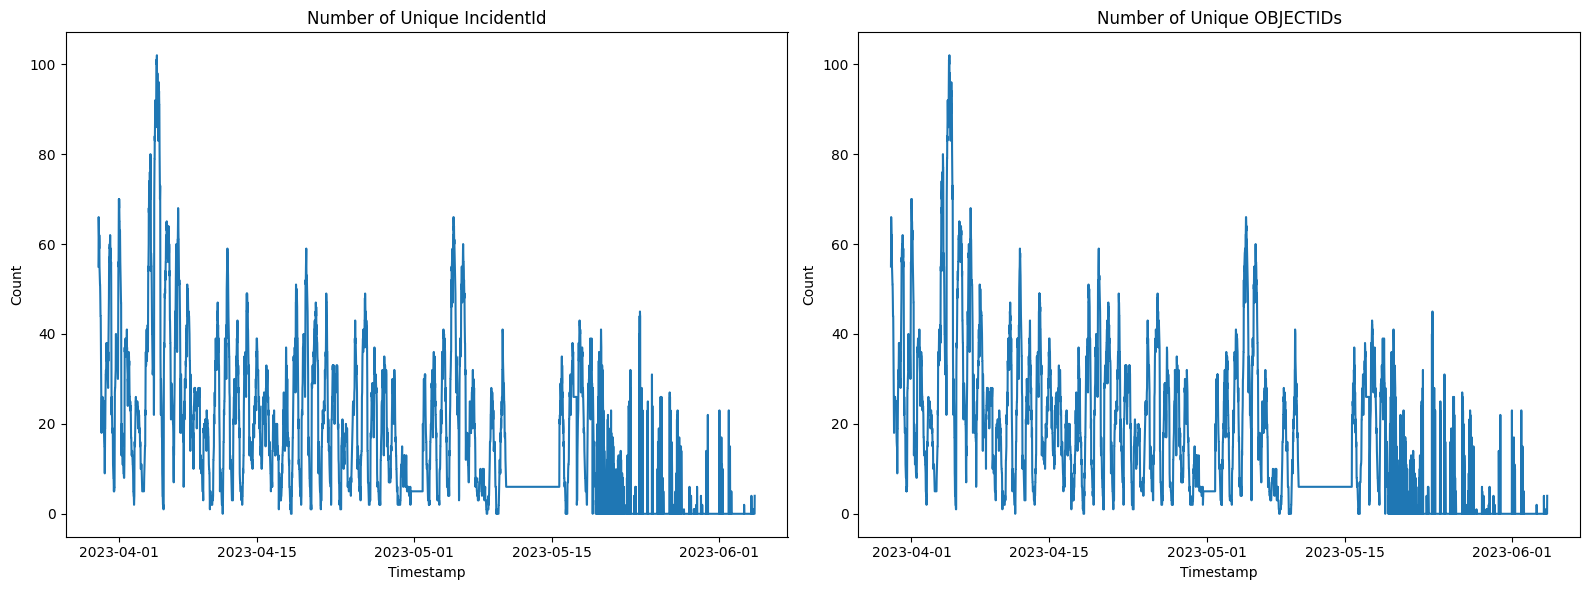

In [73]:
# Grouping by timestamp and counting unique IncidentId
unique_incidents_1 = df.groupby(pd.Grouper(key='timestamp', freq='15Min'))['IncidentId'].nunique()

# Grouping by timestamp and counting unique OBJECTID
unique_incidents_2 = df.groupby(pd.Grouper(key='timestamp', freq='15Min'))['OBJECTID'].nunique()

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Plot for unique IncidentId
axs[0].plot(unique_incidents_1.index, unique_incidents_1.values)
axs[0].set_title('Number of Unique IncidentId')
axs[0].set_xlabel('Timestamp')
axs[0].set_ylabel('Count')

# Plot for unique OBJECTID
axs[1].plot(unique_incidents_2.index, unique_incidents_2.values)
axs[1].set_title('Number of Unique OBJECTIDs')
axs[1].set_xlabel('Timestamp')
axs[1].set_ylabel('Count')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()


In [28]:
result

,x,y,timestamp,WeightedAverage
0,-118.637143,34.206769,2023-03-30 23:45:00,2.176039e+06
1,-118.637143,34.206769,2023-03-31 00:00:00,2.176042e+06
2,-118.637143,34.206769,2023-03-31 00:15:00,2.176042e+06
3,-118.637143,34.206769,2023-03-31 00:30:00,2.176042e+06
4,-118.637143,34.206769,2023-03-31 00:45:00,2.176042e+06
...,...,...,...,...
57030,-118.157280,34.110226,2023-04-05 03:30:00,2.180980e+06
57031,-118.157280,34.110226,2023-04-05 03:45:00,2.180973e+06
57032,-118.157280,34.110226,2023-04-05 04:00:00,2.180977e+06
57033,-118.157280,34.110226,2023-04-05 04:15:00,2.180977e+06


In [ ]:
# id candidate
ca['IncidentId+StartDate'] = ca['IncidentId'].astype(str) + '_' + ca['StartDate'].dt.strftime('%Y-%m-%d %H:%M:%S')
ca['coord'] = list(zip(ca['x'], ca['y']))
ca['IncidentId+Coord'] = ca['IncidentId'].astype(str) + '_' + ca['coord'].astype(str)
ca['StartDate+Coord'] = ca['StartDate'].dt.strftime('%Y-%m-%d %H:%M:%S') + '_' + ca['coord'].astype(str)
ca['IncidentId+StartDate+Coord'] = ca['StartDate'].dt.strftime('%Y-%m-%d %H:%M:%S') + '_' + ca['coord'].astype(str) + '_' + ca['IncidentId'].astype(str)

In [ ]:
import pandas as pd

# Initialize lists to hold values
utils = ca['UtilityCompany'].unique()
unique_objectid = []
unique_incidentid = []
unique_startdate = []
unique_coordinate = []
unique_incidentid_startdate = []
unique_incidentid_coord = []
unique_startdate_coord = []
unique_startdate_coord_incidentid = []

# Assuming you have a loop to generate the output values
for util in utils:
    # utils.append(util)
    unique_objectid.append(ca[ca.UtilityCompany == util]['OBJECTID'].nunique())
    unique_incidentid.append(ca[ca.UtilityCompany == util]['IncidentId'].nunique())
    unique_startdate.append(ca[ca.UtilityCompany == util]['StartDate'].nunique())
    unique_coordinate.append(ca[ca.UtilityCompany == util]['coord'].nunique())
    unique_incidentid_startdate.append(ca[ca.UtilityCompany == util]['IncidentId+StartDate'].nunique())
    unique_incidentid_coord.append(ca[ca.UtilityCompany == util]['IncidentId+Coord'].nunique())
    unique_startdate_coord.append(ca[ca.UtilityCompany == util]['StartDate+Coord'].nunique())
    unique_startdate_coord_incidentid.append(ca[ca.UtilityCompany == util]['IncidentId+StartDate+Coord'].nunique())

# Create dictionary
data = {
    'Utility': utils,
    'OBJECTID': unique_objectid,
    'IncidentId': unique_incidentid,
    'StartDate': unique_startdate,
    'Coordinate': unique_coordinate,
    'IncidentId+StartDate': unique_incidentid_startdate,
    'IncidentId+Coord': unique_incidentid_coord,
    'StartDate+Coord': unique_startdate_coord,
    'IncidentId+StartDate+Coord': unique_startdate_coord_incidentid
}

# Create DataFrame
df = pd.DataFrame(data).transpose()


In [ ]:
df

,0,1,2,3,4
Utility,LAWP,SCE,SDGE,PGE,SMUD
OBJECTID,4101,9808,3122,30796,563
IncidentId,102,6556,2795,29572,563
StartDate,4100,5736,2042,28116,614
Coordinate,116,6439,500,26324,553
IncidentId+StartDate,89321,9412,3236,30266,623
IncidentId+Coord,2589,6833,2824,29644,563
StartDate+Coord,47655,9542,2761,30258,623
IncidentId+StartDate+Coord,89321,9573,3268,30336,623


In [ ]:
sce = ca[ca['UtilityCompany'] == 'SCE']
lawp = ca[ca['UtilityCompany'] == 'LAWP']
sdge = ca[ca['UtilityCompany'] == 'SDGE']
pge = ca[ca['UtilityCompany'] == 'PGE']
smud = ca[ca['UtilityCompany'] == 'SMUD']

- for each util:
    - for each id candidate [objectid, incidentid, incidentid + startdate]
        - calculate:
            - duration (timestamp difference)
            - number of unique location ((x, y))
            - min, median, max of ImpactedCustomer
            - ImpactedCustomer X duration (timediff)

In [ ]:
import pandas as pd
from datetime import datetime

def calculate_statistics(df):
    # Convert 'StartDate' and 'timestamp' columns to datetime objects
    df['StartDate'] = pd.to_datetime(df['StartDate'])
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    
    # Initialize result dictionary to store calculated statistics
    result = {'UtilityCompany': [], 'ID Candidate': [], 'ID': [], 'Duration (minutes)': [],
              'Unique Locations': [], 'Min Impacted Customers': [], 'Median Impacted Customers': [],
              'Max Impacted Customers': []}
    
    # Iterate over each utility company
    for util in ['LAWP', 'SCE', 'SDGE', 'PGE', 'SMUD']:
        util_data = df[df['UtilityCompany'] == util]
        
        # Iterate over each ID candidate
        for id_candidate in ['OBJECTID', 'IncidentId+StartDate']:
            if id_candidate == 'OBJECTID':
                id_group = util_data.groupby('OBJECTID')
            elif id_candidate == 'IncidentId+StartDate':
                util_data.loc[:, 'IncidentId+StartDate'] = util_data['IncidentId'].astype(str) + '_' + util_data['StartDate'].dt.strftime('%Y-%m-%d %H:%M:%S')
                id_group = util_data.groupby('IncidentId+StartDate')
            
            # Calculate duration, number of unique locations, and ImpactedCustomer statistics
            for name, group in id_group:
                duration = (group['timestamp'].max() - group['timestamp'].min()).total_seconds() / 60
                unique_locations = group[['x', 'y']].drop_duplicates().shape[0]
                min_impacted = group['ImpactedCustomers'].min()
                median_impacted = group['ImpactedCustomers'].median()
                max_impacted = group['ImpactedCustomers'].max()
                
                # Append the calculated statistics to the result DataFrame
                result['UtilityCompany'].append(util)
                result['ID Candidate'].append(id_candidate)
                result['ID'].append(name)
                result['Duration (minutes)'].append(duration)
                result['Unique Locations'].append(unique_locations)
                result['Min Impacted Customers'].append(min_impacted)
                result['Median Impacted Customers'].append(median_impacted)
                result['Max Impacted Customers'].append(max_impacted)
    
    return pd.DataFrame(result)



In [ ]:

result_df = calculate_statistics(ca)

In [ ]:
result_df

,UtilityCompany,ID Candidate,ID,Duration (minutes),Unique Locations,Min Impacted Customers,Median Impacted Customers,Max Impacted Customers
0,LAWP,OBJECTID,2164236,2219.983333,1,1,1.0,1142
1,LAWP,OBJECTID,2164360,2219.983333,1,1,1.0,26
2,LAWP,OBJECTID,2164361,2219.983333,1,1,1.0,498
3,LAWP,OBJECTID,2164432,2144.983333,1,1,1.0,1046
4,LAWP,OBJECTID,2167231,540.000000,1,1,1.0,55
...,...,...,...,...,...,...,...,...
181243,SMUD,IncidentId+StartDate,D23053000079_2023-05-30 19:51:00,0.000000,1,1,1.0,1
181244,SMUD,IncidentId+StartDate,D23060100112_2023-06-01 21:44:00,26.216667,1,47,47.0,47
181245,SMUD,IncidentId+StartDate,D23060400006_2023-06-04 13:37:00,0.000000,1,10,10.0,10
181246,SMUD,IncidentId+StartDate,D23060400007_2023-06-04 13:46:00,0.000000,1,18,18.0,18


In [ ]:
lawp.ImpactedCustomers.describe()

count    107069.000000
mean         17.565953
std         139.753667
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max        7109.000000
Name: ImpactedCustomers, dtype: float64

In [ ]:

def calculate_duration_with_average(ca, util, group_keys):
    """
    Calculate the duration between the first and last timestamps for each group formed by the given keys,
    and calculate the average of the 'ImpactedCustomers' column for each group.

    Parameters:
        df (DataFrame): The DataFrame to be processed.
        group_keys (list): List of column names to group the DataFrame.

    Returns:
        DataFrame: A DataFrame containing the duration between the first and last timestamps 
                   and the average of 'ImpactedCustomers' column for each group, sorted by duration in descending order.
    """
    df = ca[ca['UtilityCompany'] == util].copy()
    # Convert the 'timestamp' column to datetime if it's not already in datetime format
    df['timestamp'] = pd.to_datetime(df['timestamp'])

    # Group by the specified keys and calculate the duration and average impacted customers
    grouped_df = df.groupby(group_keys).agg({
        'timestamp': lambda x: x.max() - x.min(),
        'ImpactedCustomers': 'mean'
    })

    # Rename columns for clarity
    grouped_df.rename(columns={'timestamp': 'Duration', 'ImpactedCustomers': 'AverageImpactedCustomers'}, inplace=True)

    # Sort by duration in descending order
    grouped_df = grouped_df.sort_values(by='Duration', ascending=False)
    display(grouped_df.head(20))

    return grouped_df

In [ ]:
for util in utils:
    print(util)
    calculate_duration_with_average(ca, util, 'IncidentId')

LAWP


,Duration,AverageImpactedCustomers
IncidentId,,
1,66 days 16:16:33,39.250286
4,66 days 16:16:33,15.193466
3,66 days 16:16:33,15.462337
2,66 days 16:16:33,25.699899
5,66 days 08:19:07,11.106457
14,64 days 04:01:24,12.472296
6,64 days 04:01:24,10.818497
15,64 days 04:01:24,13.361885
10,64 days 04:01:24,12.088638


SCE


,Duration,AverageImpactedCustomers
IncidentId,,
SCE 128583743,50 days 06:14:59,2.000000
SCE 128584071,48 days 17:29:59,43.000000
SCE 128618096,47 days 14:15:00,4.214286
SCE 128655016,42 days 07:00:00,15.000000
SCE 128716225,41 days 18:14:59,67.688432
SCE 128612415,39 days 14:30:00,8.220930
SCE 128789304,31 days 09:31:29,22.000000
SCE 128644322,30 days 17:45:01,79.070707
SCE 128418460,30 days 14:30:00,10.000000


SDGE


,Duration,AverageImpactedCustomers
IncidentId,,
1000172,6 days 22:45:00,0.0
1005441,5 days 15:15:00,1.0
1005444,5 days 14:59:59,33.0
1005459,5 days 13:30:00,14.0
1005464,5 days 13:00:00,14.0
1005467,5 days 12:15:00,109.0
1005318,5 days 10:45:00,0.0
1003987,5 days 09:45:00,0.0
1003739,5 days 09:45:00,0.0


PGE


,Duration,AverageImpactedCustomers
IncidentId,,
2078393,20 days 05:45:00,1.000000
2070824,19 days 03:14:59,10.000000
2073808,18 days 14:45:00,2.000000
2115185,17 days 15:16:33,1.000000
2086410,14 days 07:59:59,3.000000
2011718,14 days 00:59:59,3.000000
2117993,13 days 18:17:58,1.000000
2104333,13 days 09:15:00,2.109034
2033133,13 days 06:29:59,2.000000


SMUD


,Duration,AverageImpactedCustomers
IncidentId,,
D23041700025,2 days 00:15:01,1.000000
D23043000005,1 days 09:45:01,9.580882
D23042300008,1 days 00:00:01,1.000000
D23042300019,0 days 21:15:01,1.000000
D23040300038,0 days 17:59:59,1.000000
D23050500106,0 days 16:15:00,25.000000
D23042600003,0 days 15:59:59,1.969231
D23041400061,0 days 15:14:59,28.580645
D23052500044,0 days 14:15:03,1.000000


In [ ]:
def calc_corr(df, util):
    df = df[df['UtilityCompany'] == util].copy()
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    
    df['TimestampDiff'] = df['timestamp'].diff().dt.total_seconds().fillna(0)
    
    df['Coordinates'] = list(zip(df['x'], df['y']))
    
    df.corr()
    
    
    

In [ ]:
calc_corr(ca, 'SMUD')

/var/folders/3j/7cy055ys1yz5dcj9cwbxbw8h0000gp/T/ipykernel_45661/468577667.py:9: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()


In [ ]:
# pd.set_option('display.max_rows', None)
incident_frequency = df['IncidentId'].value_counts().reset_index()
incident_frequency.columns = ['IncidentId', 'Frequency']

# Merge frequency counts back into the original DataFrame
merged_df = pd.merge(df, incident_frequency, on='IncidentId')

# Sort the DataFrame by frequency in descending order
sorted_df = merged_df.sort_values(by='Frequency', ascending=False)

In [ ]:
sce = sorted_df[sorted_df['UtilityCompany'] == 'SCE']
lawp = sorted_df[sorted_df['UtilityCompany'] == 'LAWP']
sdge = sorted_df[sorted_df['UtilityCompany'] == 'SDGE']
pge = sorted_df[sorted_df['UtilityCompany'] == 'PGE']
smud = sorted_df[sorted_df['UtilityCompany'] == 'SMUD']